In [2]:
%matplotlib inline
import numpy as np
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd

# Data

In [3]:
training = pd.read_csv('Data/TrainingWiDS2021.csv', index_col=0)

In [4]:
test = pd.read_csv('Data/UnlabeledWiDS2021.csv', index_col=0)

In [5]:
train_is_positive = training['diabetes_mellitus']==1
train_is_negative = ~train_is_positive

# Analysis

## Helpers

In [6]:
def hist_by_diagnosis(feature):
    x = training[feature]
    plt.hist([x[train_is_positive], x[train_is_negative]])
    plt.title(f'Distribution of Diagnosis by {feature}')
    plt.legend(["+", "-"])

## Age

C:\Users\Brian\Anaconda3\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Brian\Anaconda3\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


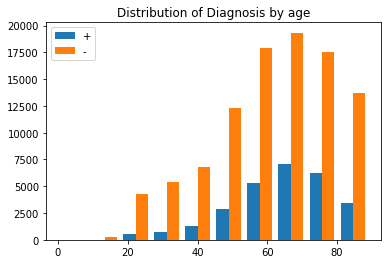

In [7]:
hist_by_diagnosis('age')

# Prediction

## Helpers

In [8]:
import sklearn.linear_model as lm
import sklearn.neighbors as nb
import sklearn.tree as tree
import sklearn.preprocessing as pp
import sklearn.ensemble as es
import sklearn.feature_selection as fs

In [9]:
def balance_training():
    has_diabetes = training[train_is_positive].sample(25000)
    no_diabetes = training[train_is_negative].sample(25000)
    return pd.concat([has_diabetes,no_diabetes])

In [10]:
def fillna(dtype, val):
    selected_cols = [col for col in training.columns if training[col].dtype == dtype]
    for col in selected_cols:
        training[col] = training[col].fillna(val)
        if col in test:
            test[col] = test[col].fillna(val)

In [11]:
def encode(column):
    global training
    global test
    all_data = pd.concat([training[[column]], test[[column]]])
    encoder = pp.OneHotEncoder()
    encoder.fit(all_data)
    columns = [column + ": " + category for category in encoder.categories_[0]]
    def apply(df):
        encodings = encoder.transform(df[[column]]).toarray()
        encodings_df = pd.DataFrame(encodings, columns=columns, index=df.index)
        df = df.join(encodings_df)
        return df.drop(columns=column)
    training = apply(training)
    test = apply(test)

In [12]:
def execute(classifier, features):
    classifier.fit(training[features], training['diabetes_mellitus'])
    test['diabetes_mellitus']=classifier.predict(test[features])
    write_solution(test)
    return classifier

In [13]:
def write_solution(solution):
    results = test[['encounter_id','diabetes_mellitus']].set_index('encounter_id')
    results.to_csv('Data/results.csv')

## Data Preparation

In [14]:
training = balance_training()

In [15]:
training['bmi'] = pd.to_numeric(training['bmi'])
test['bmi'] = pd.to_numeric(test['bmi'])

In [16]:
training['age'] = training['age'].fillna(0)

In [17]:
training['bmi'] = training['bmi'].fillna(0)
test['bmi'] = test['bmi'].fillna(0)

In [18]:
training['glucose_apache'] = training['glucose_apache'].fillna(0)
test['glucose_apache'] = test['glucose_apache'].fillna(0)

In [19]:
training['ethnicity'] = training['ethnicity'].fillna("Other/Unknown")
test['ethnicity'] = test['ethnicity'].fillna("Other/Unknown")

In [20]:
fillna('O', "Other")

In [21]:
fillna('int64', 0)
fillna('float64', 0)

In [22]:
for col in test.columns:
    if training[col].dtype == 'O':
        encode(col)

## Diagnosis = 0

In [154]:
solution = pd.read_csv('Data/SolutionTemplateWiDS2021.csv', index_col=0)

In [155]:
test['diabetes_mellitus'] = 0

In [156]:
write_solution(test)

## Diagnosis = elective_surgery

In [157]:
test['diabetes_mellitus'] = test['elective_surgery']

In [158]:
write_solution(test)

## Age logistic regression

In [159]:
clf = execute(lm.LogisticRegression(), ['age'])

C:\Users\Brian\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [160]:
X_test = np.linspace(0,100,300)

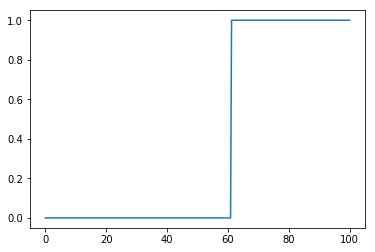

In [161]:
plt.plot(X_test, clf.predict(X_test[:,None]));

## Age + BMI logistic regression

In [162]:
execute(lm.LogisticRegression(), ['age', 'bmi']);

C:\Users\Brian\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Age + BMI kNN classifier

In [163]:
execute(nb.KNeighborsClassifier(), ['age','bmi']);

## Age, BMI, Glucose Apache kNN

In [164]:
execute(nb.KNeighborsClassifier(), ['age','bmi','glucose_apache']);

## Age, BMI, Glucose Apache logistic regression

In [165]:
execute(lm.LogisticRegression(), ['age','bmi','glucose_apache']);

C:\Users\Brian\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Decision Tree

In [166]:
execute(tree.DecisionTreeClassifier(), ['age','bmi','glucose_apache']);

## Logistic Regression all features

In [167]:
clf = execute(lm.LogisticRegression(), test.columns);

C:\Users\Brian\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brian\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


# Miscellaneous

In [168]:
test.columns

Index(['encounter_id', 'hospital_id', 'age', 'bmi', 'elective_surgery',
       'height', 'icu_id', 'pre_icu_los_days', 'readmission_status', 'weight',
       ...
       'icu_stay_type: transfer', 'icu_type: CCU-CTICU', 'icu_type: CSICU',
       'icu_type: CTICU', 'icu_type: Cardiac ICU', 'icu_type: MICU',
       'icu_type: Med-Surg ICU', 'icu_type: Neuro ICU', 'icu_type: SICU',
       'diabetes_mellitus'],
      dtype='object', length=215)

In [169]:
import sklearn.feature_selection as fs

In [170]:
training_chi = fs.SelectKBest(k=20).fit_transform(training.drop(columns=['diabetes_mellitus']), training['diabetes_mellitus'])

C:\Users\Brian\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [8] are constant.
  UserWarning)
C:\Users\Brian\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [171]:
feature_selector = fs.SelectKBest(k=40)
training_kbest = feature_selector.fit_transform(training.drop(columns=['diabetes_mellitus']), training['diabetes_mellitus'])

C:\Users\Brian\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [8] are constant.
  UserWarning)
C:\Users\Brian\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [172]:
len(feature_selector.scores_)

214

In [173]:
training_x = training.drop(columns=['diabetes_mellitus'])
len(training_x.columns)

214

In [174]:
column_scores = [(training_x.columns[i],feature_selector.scores_[i]) for i in range(len(training_x.columns))]
column_scores.sort(reverse=True, key = lambda x: x[1])
column_scores[:20]

[('d1_glucose_max', 11182.460901439825),
 ('h1_glucose_max', 3651.784536232141),
 ('h1_glucose_min', 3495.7867713126225),
 ('bmi', 1381.5958426774382),
 ('readmission_status', nan),
 ('glucose_apache', 8872.304708886166),
 ('d1_glucose_min', 1808.779206488496),
 ('d1_bun_max', 1404.264974176711),
 ('weight', 1274.8955741235877),
 ('d1_bun_min', 1221.218795848826),
 ('bun_apache', 1172.9329551503865),
 ('d1_creatinine_max', 1037.6542092258956),
 ('d1_creatinine_min', 996.934485176941),
 ('creatinine_apache', 886.5559864005222),
 ('age', 617.9718938884249),
 ('arf_apache', 593.1455038156734),
 ('d1_potassium_max', 488.76661484284597),
 ('h1_bun_min', 334.27675279875183),
 ('h1_bun_max', 333.73384202874394),
 ('d1_sysbp_max', 306.71228949048145)]

In [175]:
training_y = training['diabetes_mellitus']

In [176]:
training_x_kbest = training[training_x.columns[feature_selector.get_support()]]

In [177]:
kbest_features = training_x.columns[feature_selector.get_support()].tolist()

In [183]:
clf = execute(lm.LogisticRegression(), kbest_features)

C:\Users\Brian\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [181]:
column_scores = [(training_x.columns[i],feature_selector.scores_[i]) for i in range(len(training_x.columns))]
column_scores.sort(reverse=True, key = lambda x: x[1])
column_scores[:40]

[('d1_glucose_max', 11182.460901439825),
 ('h1_glucose_max', 3651.784536232141),
 ('h1_glucose_min', 3495.7867713126225),
 ('bmi', 1381.5958426774382),
 ('readmission_status', nan),
 ('glucose_apache', 8872.304708886166),
 ('d1_glucose_min', 1808.779206488496),
 ('d1_bun_max', 1404.264974176711),
 ('weight', 1274.8955741235877),
 ('d1_bun_min', 1221.218795848826),
 ('bun_apache', 1172.9329551503865),
 ('d1_creatinine_max', 1037.6542092258956),
 ('d1_creatinine_min', 996.934485176941),
 ('creatinine_apache', 886.5559864005222),
 ('age', 617.9718938884249),
 ('arf_apache', 593.1455038156734),
 ('d1_potassium_max', 488.76661484284597),
 ('h1_bun_min', 334.27675279875183),
 ('h1_bun_max', 333.73384202874394),
 ('d1_sysbp_max', 306.71228949048145),
 ('h1_creatinine_min', 275.4211953515131),
 ('h1_creatinine_max', 274.3312642152429),
 ('d1_potassium_min', 230.16499675851733),
 ('d1_calcium_max', 218.00390363314617),
 ('h1_potassium_max', 211.1795255875303),
 ('h1_potassium_min', 211.05245532

In [180]:
clf = execute(lm.LogisticRegression(), ['d1_glucose_max', 'bmi', 'd1_bun_max', 'd1_creatinine_max', 'age', 'arf_apache', 'd1_potassium_max', 'd1_sysbp_max'])

C:\Users\Brian\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


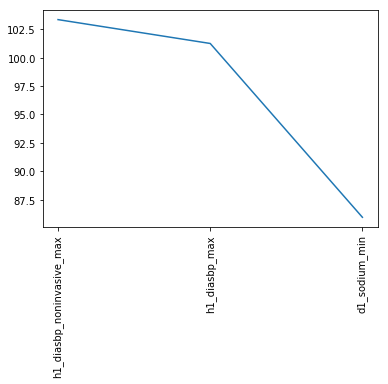

In [212]:
scores_to_plot = column_scores[40:43]
plt.plot([x[0] for x in scores_to_plot], [x[1] for x in scores_to_plot]);
plt.xticks(rotation=90);

In [25]:
clf = execute(es.RandomForestClassifier(), test.columns)

C:\Users\Brian\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


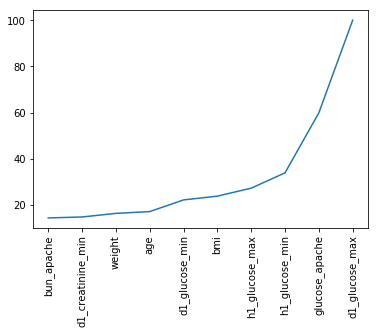

In [33]:
most_important = clf.feature_importances_.max()
feature_importance = 100.0 * clf.feature_importances_ / most_important
sorted_idx = np.argsort(feature_importance)
truncated_sorted_idx = sorted_idx[-10:]
plt.plot(test.columns[truncated_sorted_idx], feature_importance[truncated_sorted_idx])
plt.xticks(rotation=90);

In [31]:
feature_selector = fs.SelectKBest(k=40)
training_x = training.drop(columns=['diabetes_mellitus'])
training_kbest = feature_selector.fit_transform(training_x, training['diabetes_mellitus'])
kbest_features = training_x.columns[feature_selector.get_support()].tolist()

C:\Users\Brian\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [8] are constant.
  UserWarning)
C:\Users\Brian\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [40]:
clf = execute(es.RandomForestClassifier(), kbest_features)

C:\Users\Brian\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [43]:
## From https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [49]:
# execute(rf_random, test.columns) ## Takes a lot of time!

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 83.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 159.5min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [50, 266, 483, 700, 916, 1133, 1350, 1566, 1783, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [50]:
rf_random.best_params_

{'n_estimators': 266,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': True}

In [51]:
test

,encounter_id,hospital_id,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,readmission_status,weight,...,icu_stay_type: transfer,icu_type: CCU-CTICU,icu_type: CSICU,icu_type: CTICU,icu_type: Cardiac ICU,icu_type: MICU,icu_type: Med-Surg ICU,icu_type: Neuro ICU,icu_type: SICU,diabetes_mellitus
1,144740,10141,72,0.0,0,152.4,82,0.015278,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,141990,10141,86,0.0,0,175.3,82,0.000000,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
3,142038,10141,72,0.0,0,162.6,82,0.003472,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,138628,10141,66,0.0,0,177.8,82,0.884028,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
5,141682,10141,89,0.0,0,170.2,82,0.013194,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
6,139096,10141,75,0.0,0,172.7,82,0.002778,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
7,142994,10141,38,0.0,0,0.0,82,15.888889,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
8,141954,10141,87,0.0,0,152.4,82,0.056944,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
9,135344,10141,85,0.0,0,172.7,82,0.225000,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
10,142552,10141,64,0.0,0,182.9,82,0.066667,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1


In [25]:
no_h1_features = [col for col in test.columns if not col.startswith("h1")]

In [26]:
clf_lr = execute(lm.LogisticRegression(), no_h1_features)

C:\Users\Brian\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brian\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [27]:
clf_rf = execute(es.RandomForestClassifier(), no_h1_features)

C:\Users\Brian\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [30]:
clf_rf = execute(es.RandomForestClassifier(n_estimators = 250, min_samples_split = 5, min_samples_leaf = 1, max_features = 'sqrt', max_depth = 30, bootstrap = True), no_h1_features)

In [32]:
clf_rf = execute(es.RandomForestClassifier(n_estimators = 250, min_samples_split = 5, min_samples_leaf = 1, max_features = 'sqrt', max_depth = 30, bootstrap = True), kbest_features)